In [1]:
import matplotlib.pyplot as plt
import numpy as np

from biggym.envs import SchedulerEnv
from biggym.rewards.matsim import SimpleMATSimTraceScorer
from biggym.rewards.utils import NormalisedScorer

In [2]:
# Hard coded policies


class HomePolicy:
    def __call__(self, obs):
        if obs["curr_state"] == 0:
            return 2  # home -> noop
        if obs["curr_state"] == 1:
            return 0  # work -> home
        if obs["curr_state"] == 2:
            return 2  # travelling -> noop


class WorkPolicy:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def __call__(self, obs):
        state = obs["curr_state"]
        if state == 2:  # traveling
            return 2  # noop
        time = obs["time"]
        if self.start < time < self.end:
            desired_action = 1
        else:
            desired_action = 0
        if state == desired_action:
            return 2
        return desired_action


class Game:
    def __init__(self, env, discount=1.0):
        self.env = env
        self.discount = discount
        self.total_reward = 0
        self.rewards = []
        self.total_rewards = []
        self.states = []

    def run(self, policy):
        obs, info = self.env.reset()
        done = False
        while not done:
            action = policy(obs)
            obs, reward, done, _, info = self.env.step(action)
            self.total_reward = (self.total_reward * self.discount) + reward
            self.total_rewards.append(self.total_reward)
            self.rewards.append(reward)
            self.states.append(obs["curr_state"])
        return (info["trace"], reward, self.total_reward)

    def show(self):
        states = [str(s) for s in self.states]
        states = "".join(states)
        print(states)

    def plot(self):
        return plt.plot(self.rewards)


In [3]:
def run_experiment(env, max_duration, steps):
    """Dirty runner for looking at stuff."""

    # stay at home policy
    home_game = Game(env)
    policy = HomePolicy()
    trace, final_score, total_score = home_game.run(policy)

    print(
        f"Stay at home policy, total: {total_score}, last_step: {final_score}"
    )
    home_game.show()

    # 9 to 5 policy
    worker_game = Game(env)
    policy = WorkPolicy(9, 17)
    trace, final_score, total_score = worker_game.run(policy)

    print(f"9 to 5 policy, total: {total_score}, last_step: {final_score}")
    worker_game.show()

    # brute search space
    final_rewards = np.zeros((steps + 1, steps + 1))
    total_rewards = np.zeros((steps + 1, steps + 1))
    starts = np.linspace(0.0, max_duration, steps + 1)
    durations = np.linspace(0.0, max_duration, steps + 1)

    best_final_score = -np.inf
    best_total_score = -np.inf
    best_final_game = None
    best_total_game = None
    best_final_loc = None
    best_total_loc = None
    for i, start in enumerate(starts):
        for j, duration in enumerate(durations):
            end = start + duration
            if end > 24:
                final_rewards[i][j] = np.NAN
                total_rewards[i][j] = np.NAN
                continue

            game = Game(env)
            policy = WorkPolicy(start, end)
            trace, final_score, total_score = game.run(policy)
            if final_score > best_final_score:
                best_final_score = final_score
                best_final_loc = f"{start}->{end}"
                best_final_game = game
            if total_score > best_total_score:
                best_total_score = total_score
                best_total_loc = f"{start}->{end}"
                best_total_game = game

            final_rewards[i][j] = final_score
            total_rewards[i][j] = total_score

    print(f"Best final score of {best_final_score}, at {best_final_loc}")
    best_final_game.show()
    print(f"Best accumulated score of {best_total_score}, at {best_total_loc}")
    best_total_game.show()

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    img = axs[0].imshow(final_rewards, cmap="hot", interpolation="nearest")
    axs[0].set_xlabel("Duration")
    axs[0].set_ylabel("Start Time")
    plt.colorbar(img, ax=axs[0])
    axs[0].set_title("Final Step Reward Distribution")

    img = axs[1].imshow(total_rewards, cmap="hot", interpolation="nearest")
    axs[1].set_xlabel("Duration")
    axs[1].set_ylabel("Start Time")
    plt.colorbar(img, ax=axs[1])
    axs[1].set_title("Accumulated Reward Distribution")

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(home_game.rewards, label="Stay at home")
    axs[0].plot(worker_game.rewards, label="9 to 5")
    axs[0].plot(best_final_game.rewards, label="Best")
    axs[0].legend()
    axs[0].set_title("Step Rewards")

    axs[1].plot(home_game.total_rewards, label="Stay at home")
    axs[1].plot(worker_game.total_rewards, label="9 to 5")
    axs[1].plot(best_final_game.total_rewards, label="Best")
    axs[1].legend()
    axs[1].set_title("Accumulated Step Rewards")


# Vanilla MATSim Scoring

Normalised between 0 and 1 (hopefully).

The heatmaps show a brute force search of the final step reward and accumulated step reward for durations of the  home -> work -> home plan.

The best final reward is for work from 6:00 to 18:30.

The best accumulated reward is for no work, ie stay at home. This is a problem.

Stay at home policy, total: 40.31759608128251, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 39.89760766265105, last_step: 0.9596103220303769
000000000000000000022111111111111122000000000000
Best final score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000
Best accumulated score of 40.31759608128251, at 0.0->0.0
000000000000000000000000000000000000000000000000


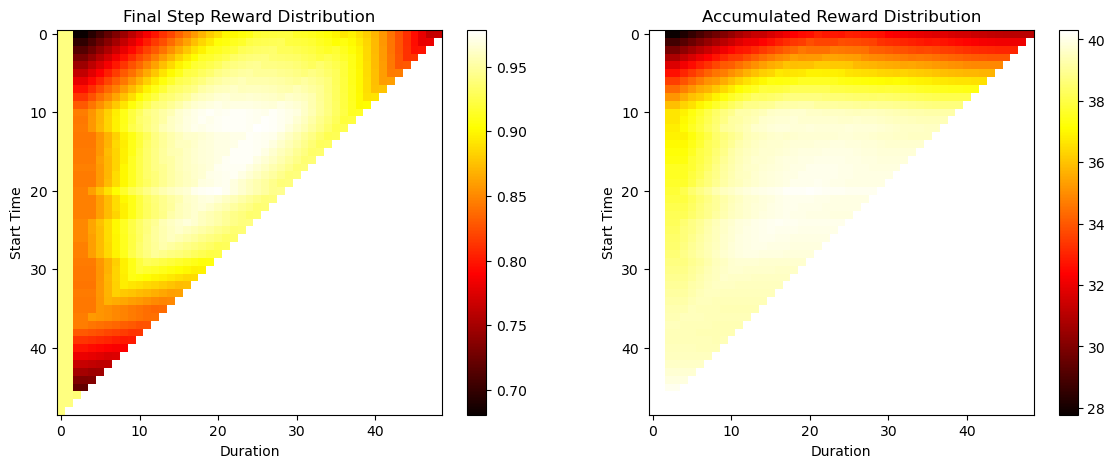

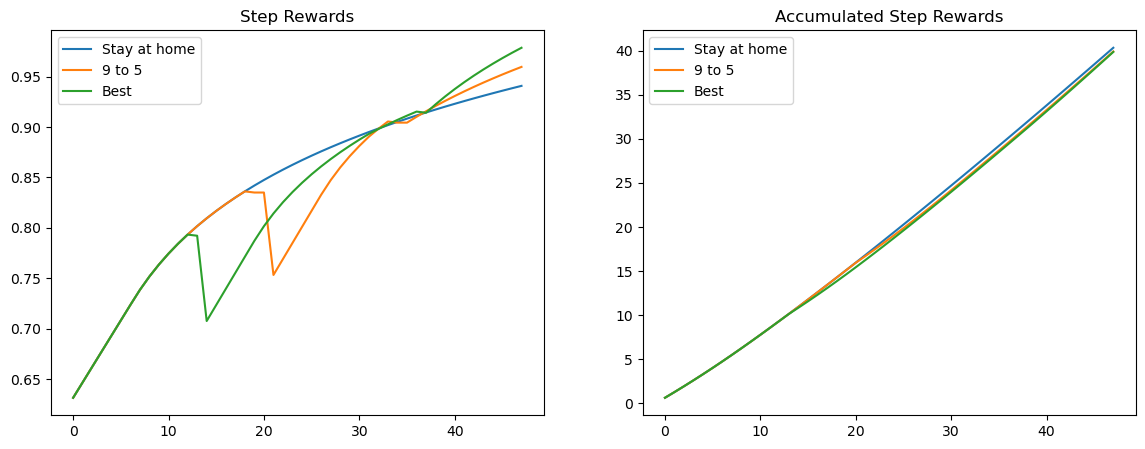

In [4]:
max_duration = 24
steps = 48

# Introduces NormalisedScorer to normalise the scores between 0 and 1 (hopefully)
scorer = NormalisedScorer(SimpleMATSimTraceScorer())
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)


# Diffing

Diffing works works to create the expected best plan from final accumulated reward (work from 6:00 to 18:00).

However note that step rewards can be negative. Also something wrong with my plots.

Stay at home policy, total: 0.9408017984455195, last_step: 0.002376071837577376
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 0.9596103220303769, last_step: 0.003700634602061492
000000000000000000022111111111111122000000000000
Best final score of 0.015339161554567937, at 0.0->20.5
021111111111111111111111111111111111111112000000
Best accumulated score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000


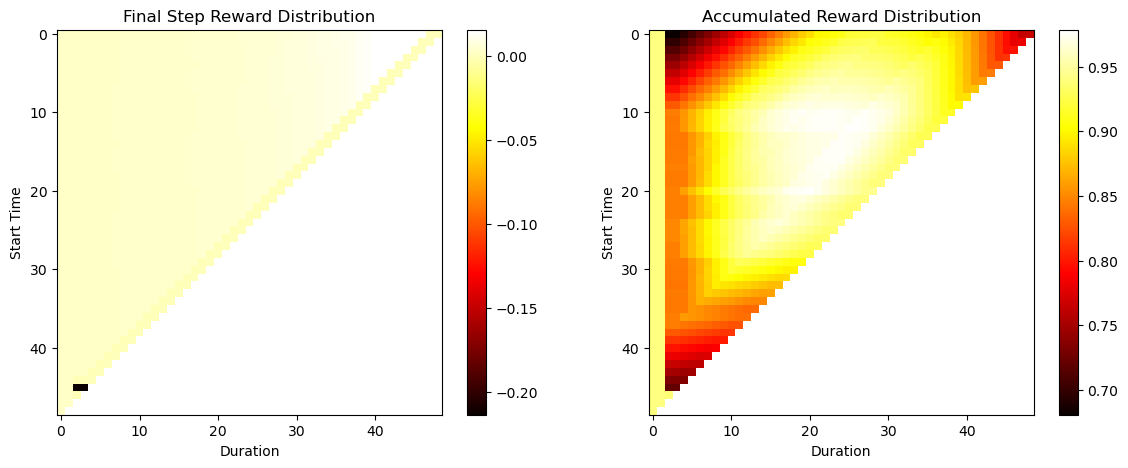

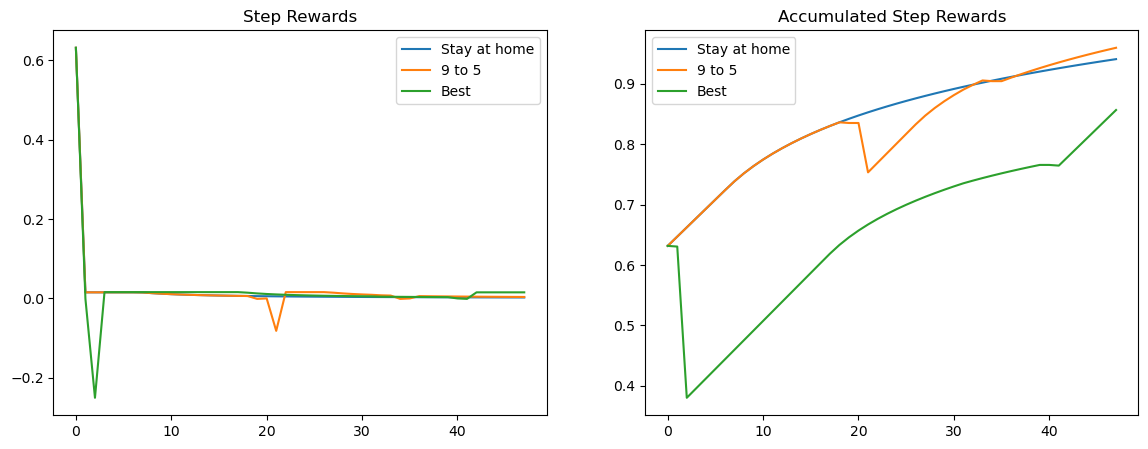

In [5]:
from biggym.rewards.utils import DiffScore

max_duration = 24
steps = 48

scorer = DiffScore(NormalisedScorer(SimpleMATSimTraceScorer()))
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)


# Consider Plan Expectation

The above rewards are generated from the plan so far at each step.

Here we add a simple rule based expectation for the whole plan (by assuming agent continues current activity until end of day).

This works to bring the rewards and accumulated rewards more in consistency with each other.

Diffing can also be added.

Stay at home policy, total: 45.15848632538495, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 45.41485419664308, last_step: 0.9596103220303769
000000000000000000022111111111111122000000000000
Best final score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000
Best accumulated score of 45.578107695449674, at 10.0->18.5
000000000000000000000211111111111111120000000000


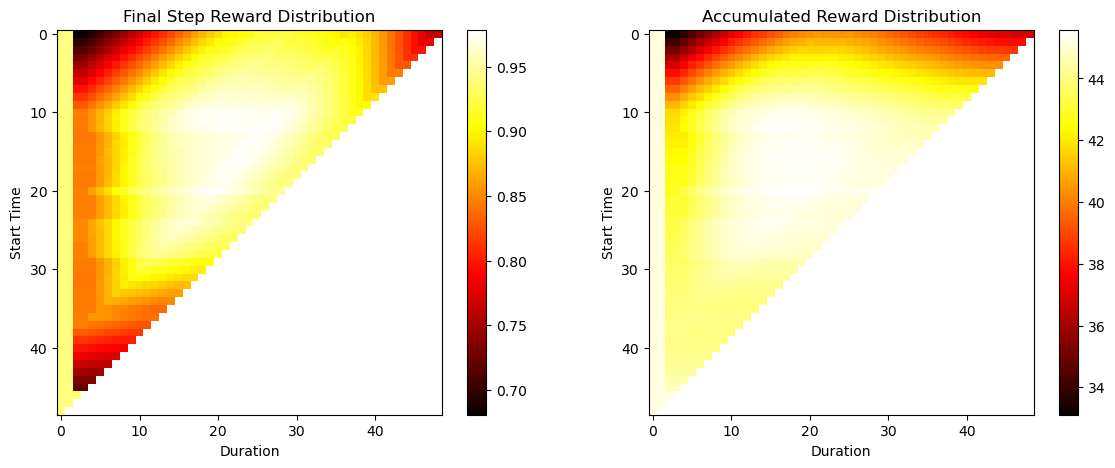

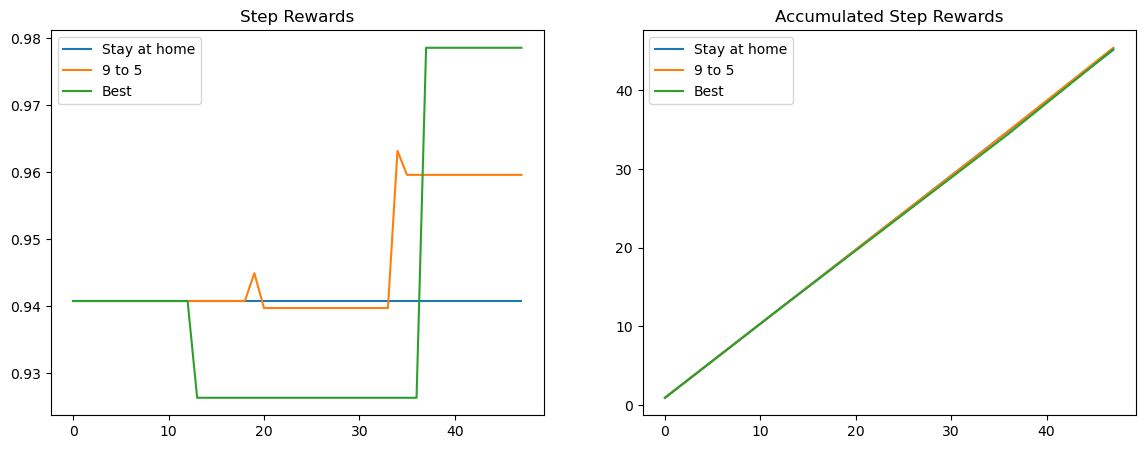

In [6]:
from biggym.rewards.expectation import ContinueDay

max_duration = 24
steps = 48

scorer = NormalisedScorer(
    scorer=SimpleMATSimTraceScorer(), expectation=ContinueDay(24)
)
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)


# Consider Better Plan Expectation

Here we add a better rule based expectation for the whole plan (by assuming agent continues current activity until trying to return home for last 6 hours).

This works to bring the rewards and accumulated rewards more in consistency with each other.

But I think some issue with implementation still...

Diffing can also be added.

Stay at home policy, total: 45.15848632538495, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 45.88871240794905, last_step: 0.9938734513625594
000000000000000000022111111111111122000000000000
Best final score of 1.0593093224378778, at 3.5->6.5
000000002111120000000000000000000000000000000000
Best accumulated score of 47.59995115144779, at 5.0->6.0
000000000002120000000000000000000000000000000000


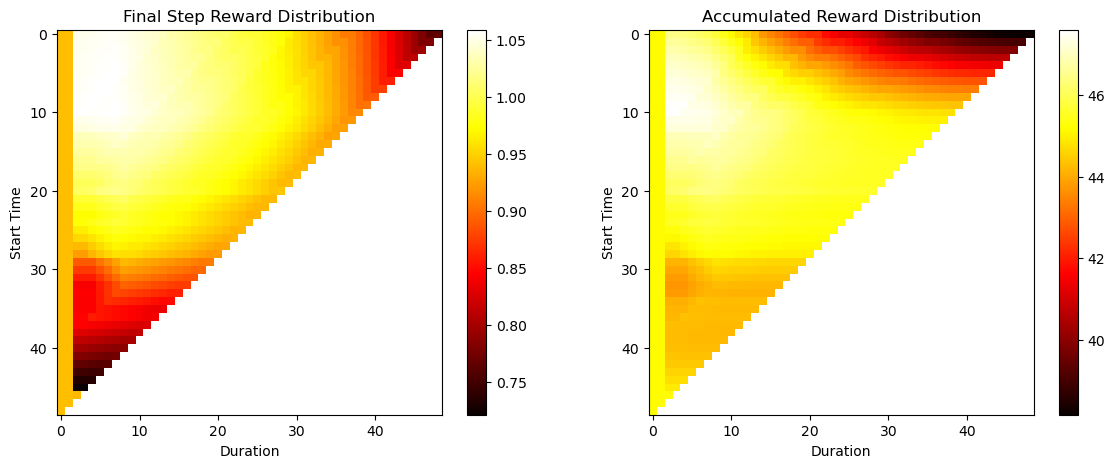

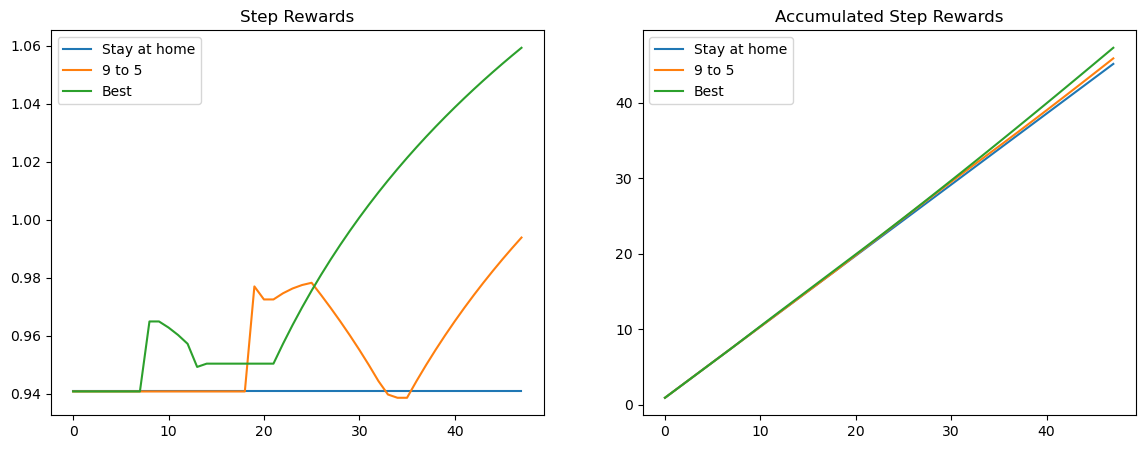

In [7]:
from biggym.rewards.expectation import ReturnDay

max_duration = 24
steps = 48

scorer = NormalisedScorer(
    scorer=SimpleMATSimTraceScorer(),
    expectation=ReturnDay(
        duration=24, return_act=0, target_duration=6, trip_idx=2
    ),
)
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)
